In [197]:
#Panda used for data manipulation
%matplotlib inline 
import pandas as pd
import seaborn as sns
from fancyimpute import IterativeImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import export_graphviz,DecisionTreeClassifier
import pydot
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#Read data
df = pd.read_csv('D:\Pavi\SLIIT Project and Assignments\SLIIT PROJECT\YEAR 4\Semester 1\Machine learning\kidney_disease.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

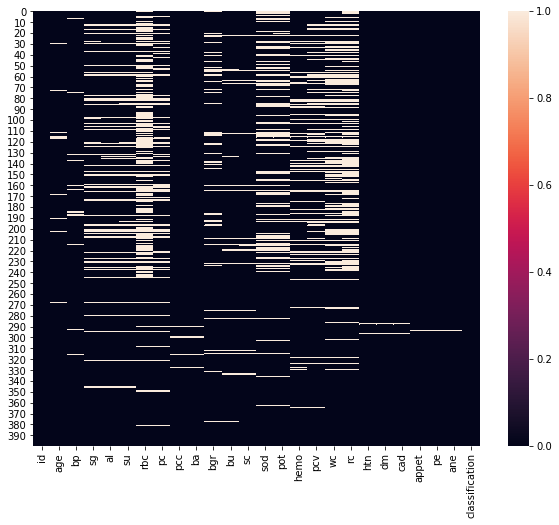

In [198]:
#Visualize the missing values in dataset
f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df.isnull())
plt.show()

In [199]:
#clean data
df.wc=df.wc.replace("\t6200",6200)
df.wc=df.wc.replace("\t8400",8400) 
df.pcv=df.pcv.replace("\t43",43)
df.classification=df.classification.replace("ckd\t","ckd") 
df.appet = df.appet.replace("no","poor")
df.cad=df.cad.replace("\tno","no")
df.dm = df.dm.replace(to_replace={'\tno':'no','\tyes':'yes',' yes':'yes', '':np.nan})
df[['rc','wc','pcv']] = df[['rc','wc','pcv']].replace(to_replace={'\t?':np.nan})

#drop column id
df.drop('id',axis=1,inplace=True)
df.head(5)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


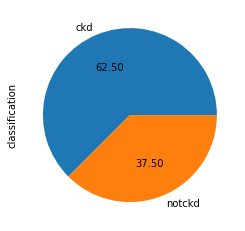

In [200]:
#pie chart to visualize the class distribution
df['classification'].value_counts().plot(kind='pie',autopct = "%.2f");

In [201]:
#instantiate OrdinalEncoder
encoder = OrdinalEncoder(dtype=np.int64)
#list of categorical column
catgry_columns = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','classification']

#function to encode categorical data to numerical
def encodeCategory(data):
    #keep only the non-null values
    nonnulls = np.array(data.dropna())
    #reshapes the array for encoding
    array_reshape = nonnulls.reshape(-1,1)
    #encode data
    encode_ordinal = encoder.fit_transform(array_reshape)
    #Assign encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(encode_ordinal)
    return data

#iterate through category columns array
for columns in catgry_columns:
    encodeCategory(df[columns]) 

df.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,1,0,0,121.0,...,44,7800,5.2,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,1,0,0,NaN,...,38,6000,NaN,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31,7500,NaN,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32,6700,3.9,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35,7300,4.6,0,0,0,0,0,0,0


In [202]:
df = df.loc[:, df.isnull().sum() < 0.2*df.shape[0]]
df.head()

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,sc,hemo,pcv,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,0,0,121.0,36.0,1.2,15.4,44,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,0,0,NaN,18.0,0.8,11.3,38,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,0,0,423.0,53.0,1.8,9.6,31,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,0,1,0,117.0,56.0,3.8,11.2,32,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,0,0,106.0,26.0,1.4,11.6,35,0,0,0,0,0,0,0


In [203]:
#impute data 
MICE_imputer = IterativeImputer()
ckd_MICE = df.copy(deep=True)
ckd_MICE.iloc[:, :] = MICE_imputer.fit_transform(ckd_MICE)

#round the values of all the columns except 'sg' to one decimal point
ckd_MICE.loc[:,df.columns != 'sg']=np.round(ckd_MICE.loc[:,df.columns != 'sg'],1)

#round 'sg' column to 3 decimal point
ckd_MICE['sg']=ckd_MICE['sg'].round(decimals=3)

ckd_MICE.head()


,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,sc,hemo,pcv,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1.0,0.0,0.0,121.0,36.0,1.2,15.4,44.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,1.0,0.0,0.0,131.9,18.0,0.8,11.3,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,1.0,0.0,0.0,423.0,53.0,1.8,9.6,31.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,0.0,117.0,56.0,3.8,11.2,32.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,1.0,0.0,0.0,106.0,26.0,1.4,11.6,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DF38841508>,
      dtype=object)

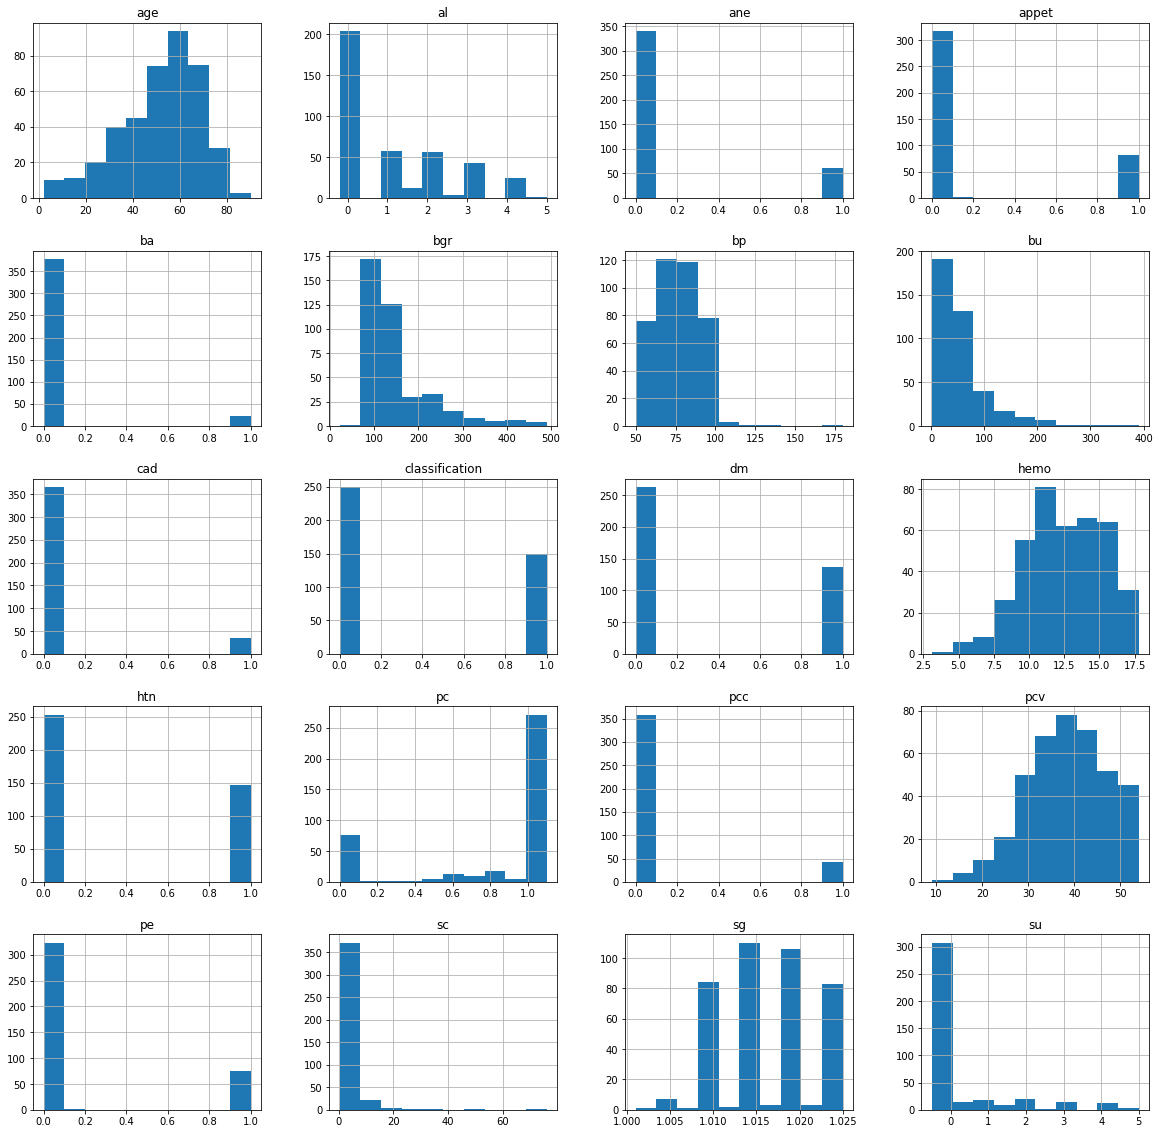

In [204]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ckd_MICE.hist(ax=ax)

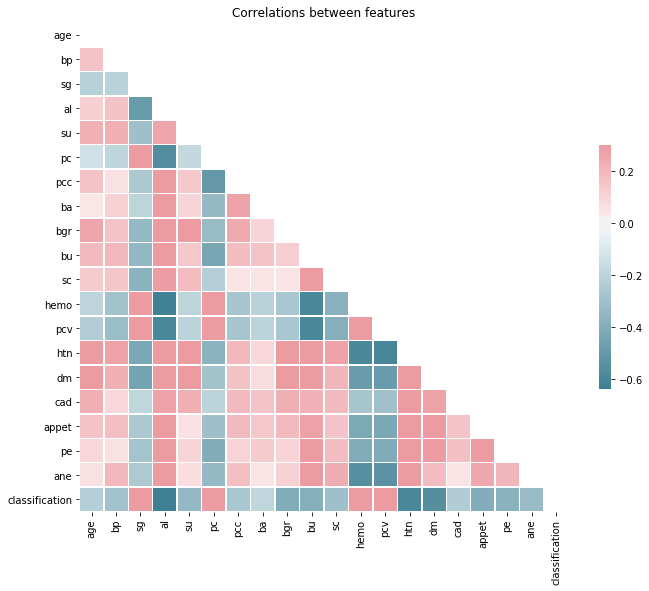

In [205]:
#create mask the size of the correlation matrix
mask = np.zeros_like(ckd_MICE.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(ckd_MICE.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between features')
plt.show()


In [206]:
#split target class and features
#retain only the features  
features= ckd_MICE.drop('classification', axis = 1)
#list of names of the features
features_list = list(features.columns)
#assign target to predict
target = ckd_MICE['classification']

In [207]:
# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(features,target,test_size=0.25,random_state=42)
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', ytrain.shape)
print('Testing Features Shape:', Xtest.shape)
print('Testing Labels Shape:', ytest.shape)

Training Features Shape: (300, 19)
Training Labels Shape: (300,)
Testing Features Shape: (100, 19)
Testing Labels Shape: (100,)


In [208]:
#random forest classifier with 1000 decision trees
RF_classifier=RandomForestClassifier(n_estimators=1000)
RF_classifier.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [209]:
#given the trained model to predict label of test data
prediction_RF=RF_classifier.predict(Xtest)
print(prediction_RF)

[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 0.]


In [210]:
#accuracy score of how exactly the labels predicted
print ('Accuracy Score :',accuracy_score(ytest, prediction_RF)) 

Accuracy Score : 1.0


Text(0.5, 1, 'Confusion matrix for CKD prediction')

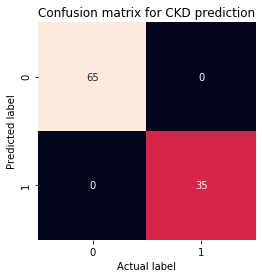

In [211]:
#confusion matrix to evaluate accuracy
matrix = confusion_matrix(ytest,prediction_RF)
sns.heatmap(matrix, square=True, annot=True, fmt='d',cbar=False)
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.title('Confusion matrix for CKD prediction')

In [212]:
#generate report showing the classification metrics
print ('Report : ')
print (classification_report(ytest, prediction_RF)); 

Report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [213]:
accuracy = cross_val_score(classifier, features, target, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy of Model with Cross Validation is: 100.0


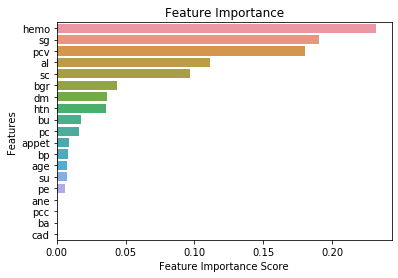

In [214]:
feature_imp = pd.Series(classifier.feature_importances_,index=features_list).sort_values(ascending=False)

sns.barplot(x=feature_imp,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

In [215]:
from IPython.display import Image
estimator = classifier.estimators_[5]
export_graphviz(estimator, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 2)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png');

In [216]:
#implememt ada boost classifier
#used ada boost for prediction to compare with RF
adaboost_classifier=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=1000)
adaboost_classifier.fit(Xtrain,ytrain)
prediction_ada=adaboost_classifier.predict(Xtest)
print('Accuracy :', accuracy_score(ytest,prediction_ada))
print('Report :')
print(classification_report(ytest,prediction_ada))

Accuracy : 0.99
Report :
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [217]:
#used SVM for prediction to compare with RF
SVM_classifier = svm.SVC(kernel='linear')
SVM_classifier.fit(Xtrain,ytrain)
prediction_svm=SVM_classifier.predict(Xtest)
print('Accuracy :', accuracy_score(ytest,prediction_svm))
print('Report :')
print(classification_report(ytest,prediction_svm))

Accuracy : 0.98
Report :
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        65
         1.0       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [218]:
#used KNN for prediction to compare with RF
KNN_classifier = KNeighborsClassifier(n_neighbors=2)
KNN_classifier.fit(Xtrain,ytrain)
prediction_knn=KNN_classifier.predict(Xtest)
print('Accuracy :', accuracy_score(ytest,prediction_knn))
print('Report :')
print(classification_report(ytest,prediction_knn))

Accuracy : 0.95
Report :
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        65
         1.0       0.89      0.97      0.93        35

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



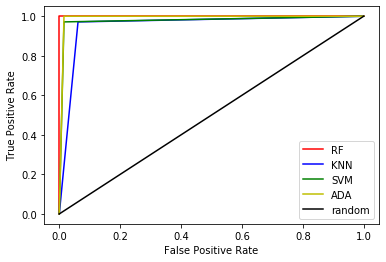

In [219]:
fpr_RF, tpr_RF, thresholds_RF = roc_curve(ytest, predict)
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(ytest, prediction_knn)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(ytest, prediction_svm)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(ytest, prediction)

plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF')
plt.plot(fpr_KNN,tpr_KNN,'b-', label= 'KNN')
plt.plot(fpr_SVM, tpr_SVM,'g-',label = 'SVM')
plt.plot(fpr_ada,tpr_ada,'y-', label= 'ADA')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()